In [1]:
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from matplotlib.colors import ListedColormap

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import string

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 16
rcParams['axes.linewidth'] = 2
rcParams['grid.linewidth'] = 2
rcParams['grid.color'] = 'gainsboro'
rcParams['font.weight'] = 'normal'
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 21
rcParams['legend.edgecolor'] = 'none'

In [3]:
reg_dic = {'0':'Liver mets',
'1':'Omentum',
'2':'RUQ',
'3':'LUQ',
'4':'Epigastrium',
'5':'Mesentery',
'6':'Left paracolic gutter',
'7':'Right paracolic gutter',
'8':'Nothing',
'9':'POD',
'10':'Nothing',
'11':'Pleural',
'12':'Abd. wall',
'13':'LN abdomen infrarenal',
'14':'LN abdomen suprarenal',
'15':'LN supradiaphragmatic',
'16':'LN chest',
'17':'LN inguinal',
'18':'Lung nodule'}

In [4]:
df_in = pd.read_csv('../prediction/inputs/training_df.csv')
df_in.head()

,Unnamed: 0,num_cycles_chemo_before_scan2,num_days_chemo1_scan1,num_days_scan2_scan1,tMAD_noSZ_first,has_doxo,has_paclit,both_weekly,both_threeweekly,paclit_one_carbop_three,...,pod_rel_change,rest_rel_change,total_vol_2,crs,debulk_status,tidied_os_or_censored_days,deceased_1_or_alive_censored_0,recurrence_1_censored_0,tidied_pfs_ct_days,id
0,0,8.0,22.0,73.0,0.009142,0.0,1.0,0.0,0.0,1.0,...,0.204594,0.000000,7.66,3,3,1295.0,1.0,1.0,700.0,338
1,1,3.0,45.0,97.0,0.015793,0.0,1.0,0.0,1.0,0.0,...,0.685166,inf,20.96,2,2,1629.0,0.0,1.0,416.0,629
2,2,3.0,35.0,88.0,0.036895,0.0,1.0,0.0,1.0,0.0,...,0.490384,0.061287,498.07,3,2,1038.0,1.0,1.0,501.0,266
3,3,3.0,4.0,56.0,0.007522,0.0,1.0,0.0,1.0,0.0,...,NaN,1.222883,2435.27,0,0,725.0,1.0,1.0,616.0,758
4,4,3.0,41.0,95.0,0.035982,0.0,1.0,0.0,1.0,0.0,...,0.110882,0.000000,90.65,3,2,1052.0,1.0,1.0,441.0,611


In [5]:
df_aux1 = pd.read_csv('../data/neov-segmentation-volumes.csv')
df_aux1.head()

,Unnamed: 0,patientID,scan_date_1,n_lesions_v0_1,n_lesions_v1_1,n_lesions_v10_1,n_lesions_v100_1,mean_vol_1,median_vol_1,max_vol_1,...,num_scans_diff,sorting_date_diff,relative_change,quad1,quad2,quad3,quad4,om_rel_change,pod_rel_change,rest_rel_change
0,1,38,20091012,71,37,10,1,13.80,1.04,597.95,...,0,99 days 00:00:00.000000000,0.919288,False,False,False,True,0.972389,0.865791,0.807112
1,3,72,20100521,25,16,6,1,14.11,1.70,115.05,...,0,81 days 00:00:00.000000000,0.167508,True,False,False,False,0.151202,0.240311,0.101128
2,6,75,20100514,5,3,2,0,20.57,9.37,56.19,...,0,67 days 00:00:00.000000000,0.085959,True,False,False,False,0.013644,0.176483,NaN
3,8,78,20100419,6,2,2,1,40.44,0.49,188.30,...,0,100 days 00:00:00.000000000,0.205967,True,False,False,False,0.297205,0.177377,0.600000
4,10,95,20100816,2,2,1,0,13.32,13.32,19.01,...,0,37 days 00:00:00.000000000,0.577169,False,False,True,False,NaN,0.600736,0.518373


In [6]:
df_recist = pd.read_csv('../data/neov-recist.csv')[['ID','recist_summed_diameter_scan2','response_volume']]
df_extra = pd.read_csv('../data/neov-extra-annotations.csv')[['ID','Ascites_scan2','pleural_effusion_scan2']]


In [7]:
new_cols = [x for x in df_aux1.columns.values if x not in df_in.columns.values]
df = pd.merge(left=df_in, right=df_aux1[new_cols], left_on='id', right_on='patientID', how='inner')
df = pd.merge(left=df, right=df_recist, left_on='id', right_on='ID', how='inner')
df = pd.merge(left=df, right=df_extra, left_on='id', right_on='ID', how='inner')

In [8]:
df['rel_vol_change'] = (df['total_vol_2'])/df['total_vol_1']
df['rel_recist_change'] = (df['recist_summed_diameter_scan2']-df['recist_summed_diameter_scan1'])/df['recist_summed_diameter_scan1']

## Lymph node variable

In [9]:
named_feats = list(df.columns.values)
for site in list(reg_dic.keys())[::-1]:
    named_feats = [sub.replace(site, reg_dic[site]) for sub in named_feats]

In [10]:
# Scan 1
ln_vars = []
for namedvar, numvar in zip(named_feats, df.columns.values): 
    if ('LN' in namedvar) and ('vol_1' in numvar): 
        ln_vars.append(numvar)
sum_vol_lns = np.zeros_like(df['stage'].values)
for ln_var in ln_vars: 
    sum_vol_lns = sum_vol_lns + df[ln_var].values
df['LN_total_vol_1'] = sum_vol_lns

In [11]:
# Scan 2
ln_vars = []
for namedvar, numvar in zip(named_feats, df.columns.values): 
    if ('LN' in namedvar) and ('vol_2' in numvar): 
        ln_vars.append(numvar)
sum_vol_lns = np.zeros_like(df['stage'].values)
for ln_var in ln_vars: 
    sum_vol_lns = sum_vol_lns + df[ln_var].values
df['LN_total_vol_2'] = sum_vol_lns

## Survival

In [12]:
survival_colors = ['green','skyblue','firebrick']

def plot_KM(outcome, stratifier, groups, labels, survival_days, survival_cens):
    alphabet = string.ascii_uppercase

    plt.figure(figsize=(5,5))
    kmfs = []
    for i,ig in enumerate(groups):
        ## fit the model for 1st cohort
        kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
        kmf1.fit(survival_days[ig], survival_cens[ig], label='{}'.format(labels[i]))
        if i==0:
            a1 = kmf1.plot(ci_show=False, show_censors=True, linewidth=3, color=survival_colors[i])
        else:
            kmf1.plot(ax=a1,ci_show=False, show_censors=True, linewidth=3, color=survival_colors[i])
        kmfs.append(kmf1)
            
    for i in range(0,len(groups)):
        if i==1:
            continue
        p = logrank_test(
            survival_days[groups[1]], survival_days[groups[i]],
            event_observed_A=survival_cens[groups[1]],
            event_observed_B=survival_cens[groups[i]]).p_value
        if outcome=='PFS':
            plt.text(1100,0.6-(i-1)*0.05,'B vs {}: p={:.2f}'.format(alphabet[i], p))
        else:
            plt.text(1500,0.6-(i-1)*0.05,'B vs {}: p={:.2f}'.format(alphabet[i], p))
        print('B vs {}: p={:.2f}'.format(alphabet[i], p))
   

    plt.ylabel(outcome)    
    plt.xlabel('Days')
    plt.show()

In [13]:
def multiKM(groups,cuts,variable):
    all_strats = []
    all_names = []
    ordered_letters = ['A', 'B', 'C']
    for i in range(len(cuts)-1): 
        lowc = np.percentile(groups,cuts[i])
        highc = np.percentile(groups,cuts[i+1])
        strat = ((groups>=lowc) & (groups<highc))
        if i==len(cuts)-2:
            print('Final one')
            strat = (groups>=lowc)
        if i==0:
            print('First one')
            strat = groups<highc
        all_strats.append(strat)
        all_names.append('{}: {}-{} perc.'.format(ordered_letters[i],cuts[i],cuts[i+1]))
    plot_KM('PFS',variable,all_strats,all_names,pfs_survival_days,pfs_survival_cens)
    plot_KM('OS',variable,all_strats,all_names,os_survival_days,os_survival_cens)

In [14]:
def printLatexSummary(cph):
    output = '{:.4f} & {:.4f} & {:.4f} & {:.4f}--{:.4f} & {:.4f} & {:.4f}'.format(cph.params_.iloc[0],
                        cph.standard_errors_.iloc[0], cph.hazard_ratios_.iloc[0],
                        cph.confidence_intervals_.iloc[0,0], cph.confidence_intervals_.iloc[0,1],
                        cph._compute_z_values().iloc[0], cph._compute_p_values()[0])
    print('Parameter estimate & Standard error & HR & 95\% CI & z-score & p-value')
    print(output)

In [15]:
os_survival_days = df['tidied_os_or_censored_days']
os_survival_cens = df['deceased_1_or_alive_censored_0']

pfs_survival_days = df['tidied_pfs_ct_days']
pfs_survival_cens = df['recurrence_1_censored_0']

## 1. RECIST

B vs A: p=0.26
B vs C: p=0.87


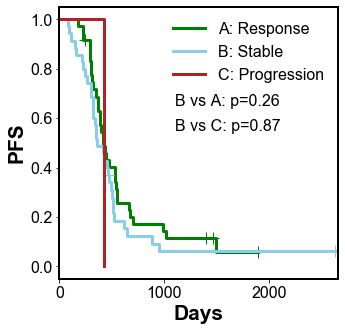

B vs A: p=0.35
B vs C: p=0.87


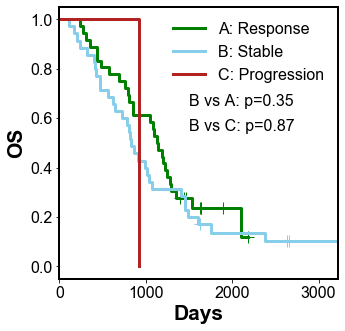

In [16]:
groups = df['response_volume']
i1 = (groups == 'response')
i2 = (groups == 'stable')
i3 = (groups == 'progression')
plot_KM('PFS','RECIST',[i1,i2,i3],['A: Response','B: Stable','C: Progression'],pfs_survival_days,pfs_survival_cens)
plot_KM('OS','RECIST',[i1,i2,i3],['A: Response','B: Stable','C: Progression'],os_survival_days,os_survival_cens)

In [17]:
print('PFS')
cph = CoxPHFitter()
pred = pd.factorize(df['response_volume'])[0]
cox_df = pd.DataFrame(pred, columns=['response_volume'])
cox_df['pfs_ct_days'] = df['tidied_pfs_ct_days']
cox_df['recurrence_1_censored_0'] = df['recurrence_1_censored_0']
cph.fit(cox_df, duration_col='pfs_ct_days', event_col='recurrence_1_censored_0')
cph.print_summary()  # access the individual results using cph.summary
cph.check_assumptions(cox_df)
printLatexSummary(cph)


PFS


Proportional hazard assumption looks okay.
Parameter estimate & Standard error & HR & 95\% CI & z-score & p-value
0.2681 & 0.2347 & 1.3075 & -0.1920--0.7282 & 1.1420 & 0.2534


In [18]:
print('OS')
cph = CoxPHFitter()
pred = pd.factorize(df['response_volume'])[0]
cox_df = pd.DataFrame(pred, columns=['response_volume'])
cox_df['os_or_censored_days'] = df['tidied_os_or_censored_days']
cox_df['deceased_1_or_alive_censored_0'] = df['deceased_1_or_alive_censored_0']
cph.fit(cox_df, duration_col='os_or_censored_days', event_col='deceased_1_or_alive_censored_0')
cph.print_summary()  # access the individual results using cph.summary
cph.check_assumptions(cox_df)
printLatexSummary(cph)


OS


Proportional hazard assumption looks okay.
Parameter estimate & Standard error & HR & 95\% CI & z-score & p-value
0.2548 & 0.2474 & 1.2901 & -0.2301--0.7396 & 1.0299 & 0.3030


## 2. Volume change

First one
Final one
B vs A: p=0.01
B vs C: p=0.29


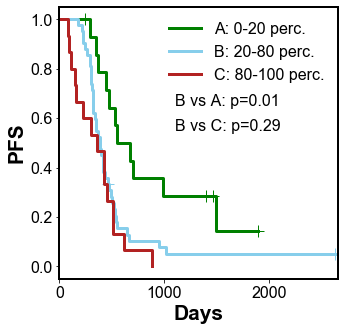

B vs A: p=0.11
B vs C: p=0.03


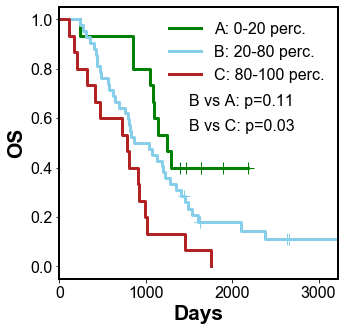

In [19]:
groups_vol = df['relative_change']
multiKM(groups_vol,[0,20,80,100],'Total volume change')

In [20]:
print('PFS')
cph = CoxPHFitter()
cox_df = pd.DataFrame(df['relative_change'], columns=['relative_change'])
cox_df['pfs_ct_days'] = df['tidied_pfs_ct_days']
cox_df['recurrence_1_censored_0'] = df['recurrence_1_censored_0']
cph.fit(cox_df, duration_col='pfs_ct_days', event_col='recurrence_1_censored_0')
cph.print_summary()  # access the individual results using cph.summary
cph.check_assumptions(cox_df)
printLatexSummary(cph)

PFS


Proportional hazard assumption looks okay.
Parameter estimate & Standard error & HR & 95\% CI & z-score & p-value
0.5540 & 0.3134 & 1.7402 & -0.0603--1.1684 & 1.7676 & 0.0771


In [21]:
print('OS')
cph = CoxPHFitter()
cox_df = pd.DataFrame(df['relative_change'], columns=['relative_change'])
cox_df['os_or_censored_days'] = df['tidied_os_or_censored_days']
cox_df['deceased_1_or_alive_censored_0'] = df['deceased_1_or_alive_censored_0']
cph.fit(cox_df, duration_col='os_or_censored_days', event_col='deceased_1_or_alive_censored_0')
cph.print_summary()  # access the individual results using cph.summary
cph.check_assumptions(cox_df)
printLatexSummary(cph)


OS


Proportional hazard assumption looks okay.
Parameter estimate & Standard error & HR & 95\% CI & z-score & p-value
0.7372 & 0.3308 & 2.0901 & 0.0889--1.3855 & 2.2287 & 0.0258


## 3. Summed diameters

First one
Final one
B vs A: p=0.03
B vs C: p=0.57


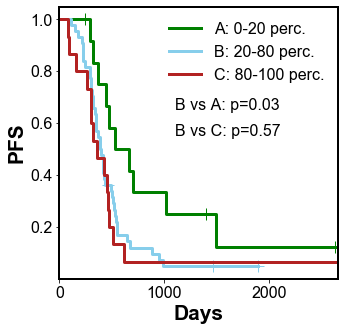

B vs A: p=0.07
B vs C: p=0.45


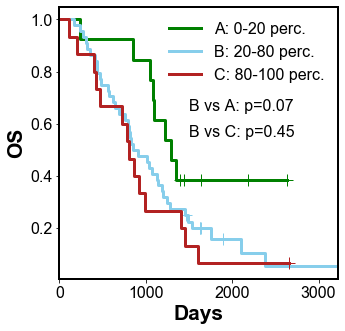

In [22]:
groups = df['recist_summed_diameter_scan2'].values/df['recist_summed_diameter_scan1'].values
multiKM(groups,[0,20,80,100],'RECIST diameter ratio')

In [23]:
print('PFS')
cph = CoxPHFitter()
cox_df = pd.DataFrame(groups, columns=['diam_change'])
cox_df['pfs_ct_days'] = df['tidied_pfs_ct_days']
cox_df['recurrence_1_censored_0'] = df['recurrence_1_censored_0']
cph.fit(cox_df, duration_col='pfs_ct_days', event_col='recurrence_1_censored_0')
cph.print_summary()  # access the individual results using cph.summary
cph.check_assumptions(cox_df)
printLatexSummary(cph)


PFS


Proportional hazard assumption looks okay.
Parameter estimate & Standard error & HR & 95\% CI & z-score & p-value
1.3414 & 0.5459 & 3.8244 & 0.2715--2.4113 & 2.4574 & 0.0140


In [24]:
print('OS')
cph = CoxPHFitter()
cox_df = pd.DataFrame(groups, columns=['diam_change'])
cox_df['os_or_censored_days'] = df['tidied_os_or_censored_days']
cox_df['deceased_1_or_alive_censored_0'] = df['deceased_1_or_alive_censored_0']
cph.fit(cox_df, duration_col='os_or_censored_days', event_col='deceased_1_or_alive_censored_0')
cph.print_summary()  # access the individual results using cph.summary
cph.check_assumptions(cox_df)
printLatexSummary(cph)


OS


Proportional hazard assumption looks okay.
Parameter estimate & Standard error & HR & 95\% CI & z-score & p-value
1.1173 & 0.5734 & 3.0567 & -0.0065--2.2411 & 1.9486 & 0.0513
